The goal of this project is to use a data driven method to greatly simplify the simulation of a beam of charged particles going through a series of magnetic lenses. This method brings computation times from hours of complicated and overdetailed simulation (which were also difficult to correlate to reality) down to real time simulation. The main limitation is currently the small sample size. However, the model can easily be scaled once more data becomes available.

This is the notebook used to train and test various models. It's not the cleanest implementation as this was written in prototyping phase and many different approaches were tried. 

First of all, we import libraries and datasets:

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.optim
from torch.optim import SGD
from torch.optim import Adam
from torch import nn
from tqdm import tqdm
from os.path import join
import datetime
from matplotlib import pyplot as plt

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

data = pd.read_excel("./CATANA_clean.xls", sheet_name=0, header=0).fillna(0)
data1 = pd.read_excel("./MAGNEX.xls", sheet_name=0, header=0).fillna(0)
data2 = pd.read_excel("./TEBE.xls", sheet_name=0, header=0).fillna(0)
data3 = pd.read_excel("./ZERO GRADI.xls", sheet_name=0, header=0).fillna(0)

data = data.drop(labels=["EXFC1", "EXFC2"], axis=1)
data1 = data1.drop(labels=["Data"], axis=1)
data2 = data2.drop(labels=["Data"], axis=1)
data3 = data3.drop(labels=["Data"], axis=1)

# Merging data
data = data.append(data1, ignore_index=True)
data = data.append(data2, ignore_index=True)
data = data.append(data3, ignore_index=True)

data = data.fillna(0)
data.head()

,CMx-EXQU1,CMy-EXQU1,STDx-EXQU1,STDy-EXQU1,EXST2x,EXQP1,EXST3x,EXQP2,EXST4y,EXQP3,EXST5y,EXST5x,CMx-EXQU2,CMy-EXQU2,STDx-EXQU2,STDy-EXQU2
0,340,370,44,9,3.0,67.0,0.0,83.5,3.0,0.0,3.0,-2.0,368,355,49,21
1,340,366,34,8,2.0,70.5,-1.7,84.5,3.0,0.0,2.8,0.0,349,364,27,17
2,334,366,32,8,2.0,70.5,-1.7,84.5,3.0,0.0,2.8,0.0,351,362,29,18
3,339,367,34,10,3.5,67.5,0.9,85.5,3.1,0.0,3.0,0.0,359,360,35,21
4,377,346,42,17,4.1,72.0,0.6,85.0,2.5,0.0,0.9,0.0,411,339,40,21


This data contains info about the beam of particles and the configuration of the magnetic lenses. 
The first 4 columns contain the position an dimension of the beam before encountering a series of magnetic lenses. These magnetic lenses are fixed in position so that the only parameter needed to study them is the electric current flowing through each lens which determines all its deflecting properties. These currents are recorded in the 'middle' columns. 
The last 4 columns contain the position and dimensions of the beam after the series of lenses. 
The goal is to predict these last 4 columns using all the rest of the data as input of a neural network. 

Data is normalized and shuffled:

In [8]:
data_norm = ((data - data.min()) / (data.max() - data.min())).fillna(0)

random_seed = 1234
data_shuffle = data_norm.sample(frac=1, random_state=random_seed)
test_len = int(len(data)*0.25)
datarray = np.array(data_shuffle[:-test_len])
datarray_test = np.array(data_shuffle[-test_len:])
datarray.shape, datarray_test.shape

((75, 16), (24, 16))

In [9]:
datarray_in = torch.Tensor(datarray[:, :-4]).to(device)
datarray_out = torch.Tensor(datarray[:, -4:]).to(device)
datatest_in = torch.Tensor(datarray_test[:, :-4]).to(device)
datatest_out = torch.Tensor(datarray_test[:, -4:]).to(device)


Next we have the model and a training pipeline

In [10]:
class BeamNetV4(nn.Module):
    def __init__(self):
        super(BeamNetV4, self).__init__()
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.fc1 = nn.Sequential(
            nn.Linear(12, 100), nn.Linear(100, 100), nn.Linear(100, 150)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(150, 100), nn.Linear(100, 75), nn.Linear(75, 4)
        )

    def forward(self, x):

        out = self.fc1(x.float().view(-1, 12))
        out = self.fc2(out).view(-1, 4)

        return out
    
def train(
    model,
    epochs,
    datarray_in,
    datarray_out,
    datatest_in,
    datatest_out,
    device=device,
    lr=0.001,
    momentum=0.9,
    logdir="logs",
    exp_name="secondo",
    log_interval=100,
):
    #     criterion = nn.MSELoss()
    losses_train = []
    losses_test = []
    datarray_in = datarray_in.to(device)
    datarray_out = datarray_out.to(device)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    run_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    # writer = SummaryWriter(join(logdir, exp_name, str(run_date)))
    for e in tqdm(range(epochs)):
        #         print(model(datarray_in))

        # Training
        with torch.set_grad_enabled(True):
            optimizer.zero_grad()
            outs = model(datarray_in)
            loss = criterion(outs.view(-1, 4), datarray_out.view(-1, 4))
            #             writer.add_scalar('Loss', loss, global_step=e)
            loss.backward()
            losses_train.append(loss.item())
            optimizer.step()

        # Testing
        with torch.set_grad_enabled(False):
            test_out = model(datatest_in)
            loss_test = criterion(test_out.view(-1, 4), datatest_out.view(-1, 4))
            losses_test.append(loss_test.item())
        #             writer.add_scalar('Loss_test', loss_test, global_step=e)

        if e % log_interval == 0:
            # writer.add_scalar("Loss", loss, global_step=e)
            # writer.add_scalar("Loss_test", loss_test, global_step=e)
            plt.plot(losses_train, label="train")
            plt.plot(losses_test, label="test")
            plt.legend()
            plt.show()

We can now start training!

  0%|          | 0/300 [00:00<?, ?it/s]

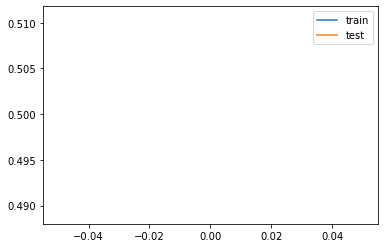

 13%|█▎        | 40/300 [00:01<00:06, 40.46it/s]

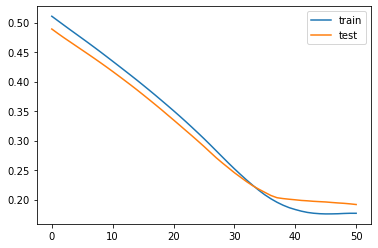

 32%|███▏      | 97/300 [00:02<00:03, 60.11it/s]

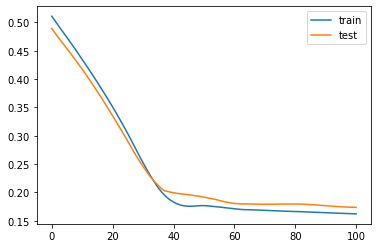

 49%|████▊     | 146/300 [00:04<00:02, 66.25it/s]

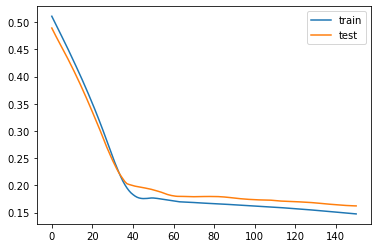

 64%|██████▍   | 193/300 [00:05<00:01, 66.56it/s]

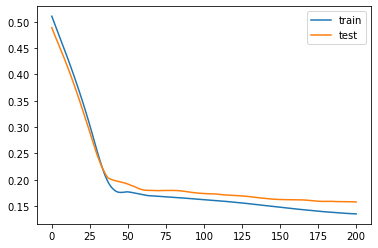

 82%|████████▏ | 247/300 [00:06<00:00, 74.12it/s]

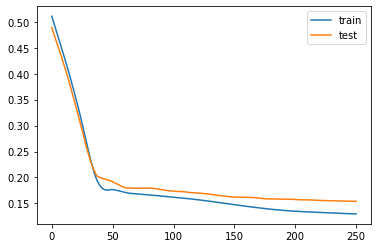

100%|██████████| 300/300 [00:07<00:00, 42.22it/s]


In [11]:
model = BeamNetV4().to(device)

# %% ##############################################################################################
################################## Train ##########################################################
train(
    model,
    epochs = 300,
    datarray_in=datarray_in,
    datarray_out=datarray_out,
    datatest_in=datatest_in,
    datatest_out=datatest_out,
    lr=0.0001,
    log_interval=50,
    exp_name="Bigger_dataset_BeamV4_prova",
)

We can now compare the model when trained on different sized datasets

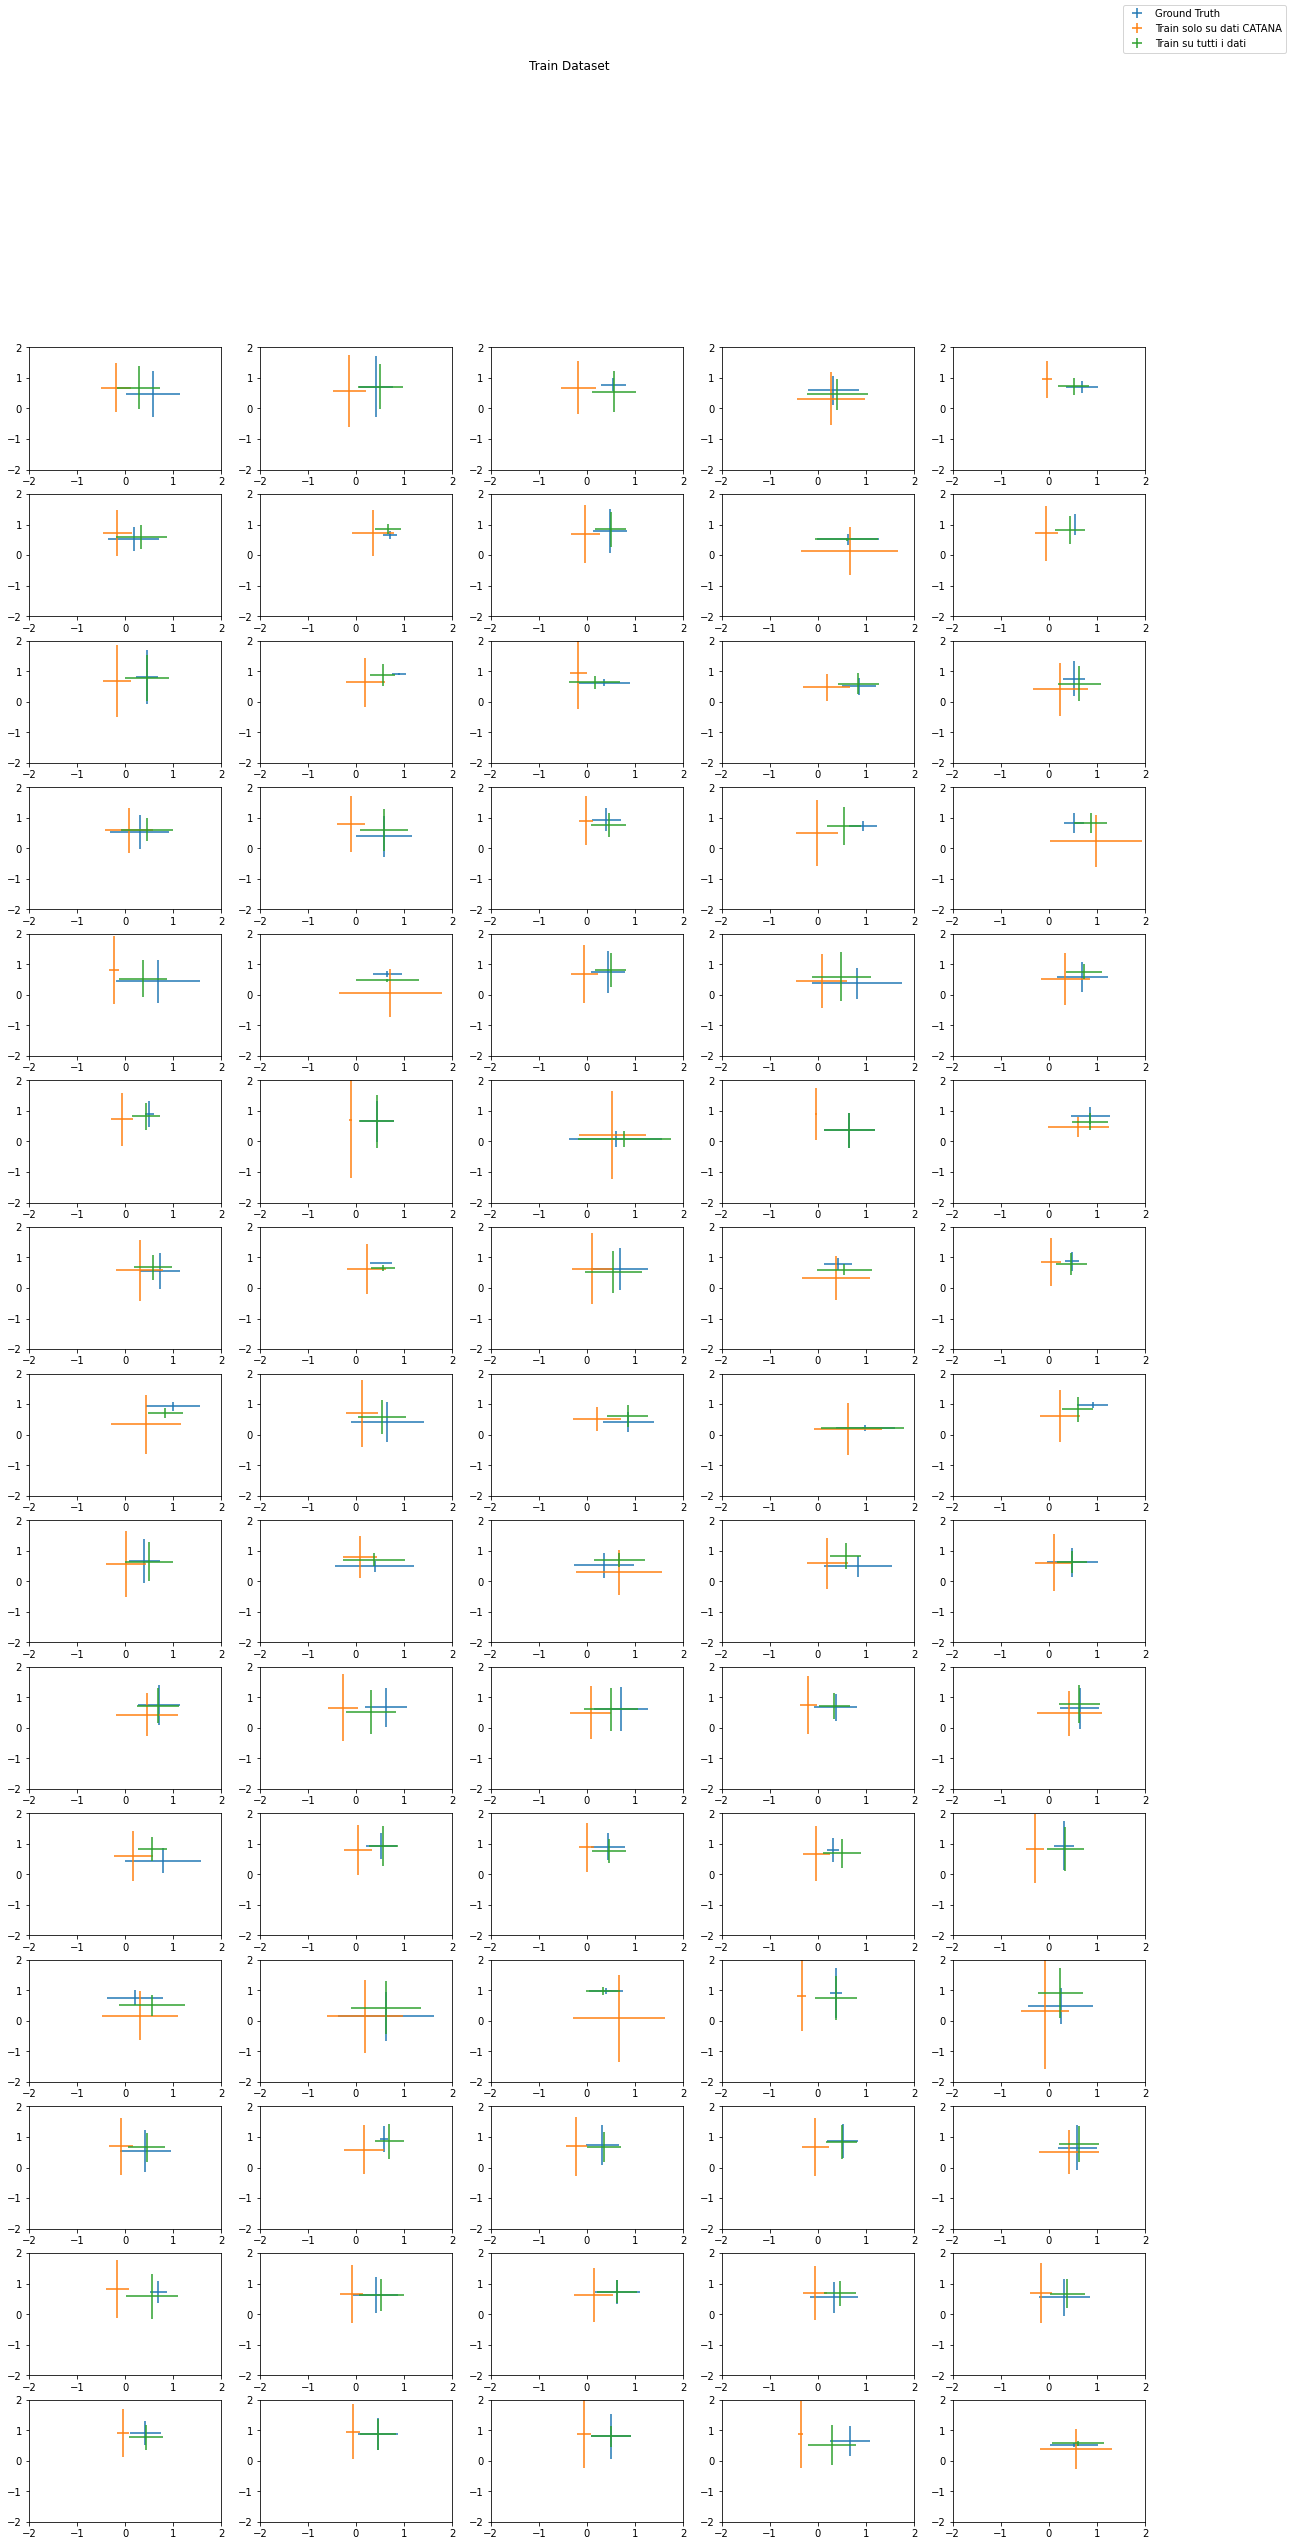

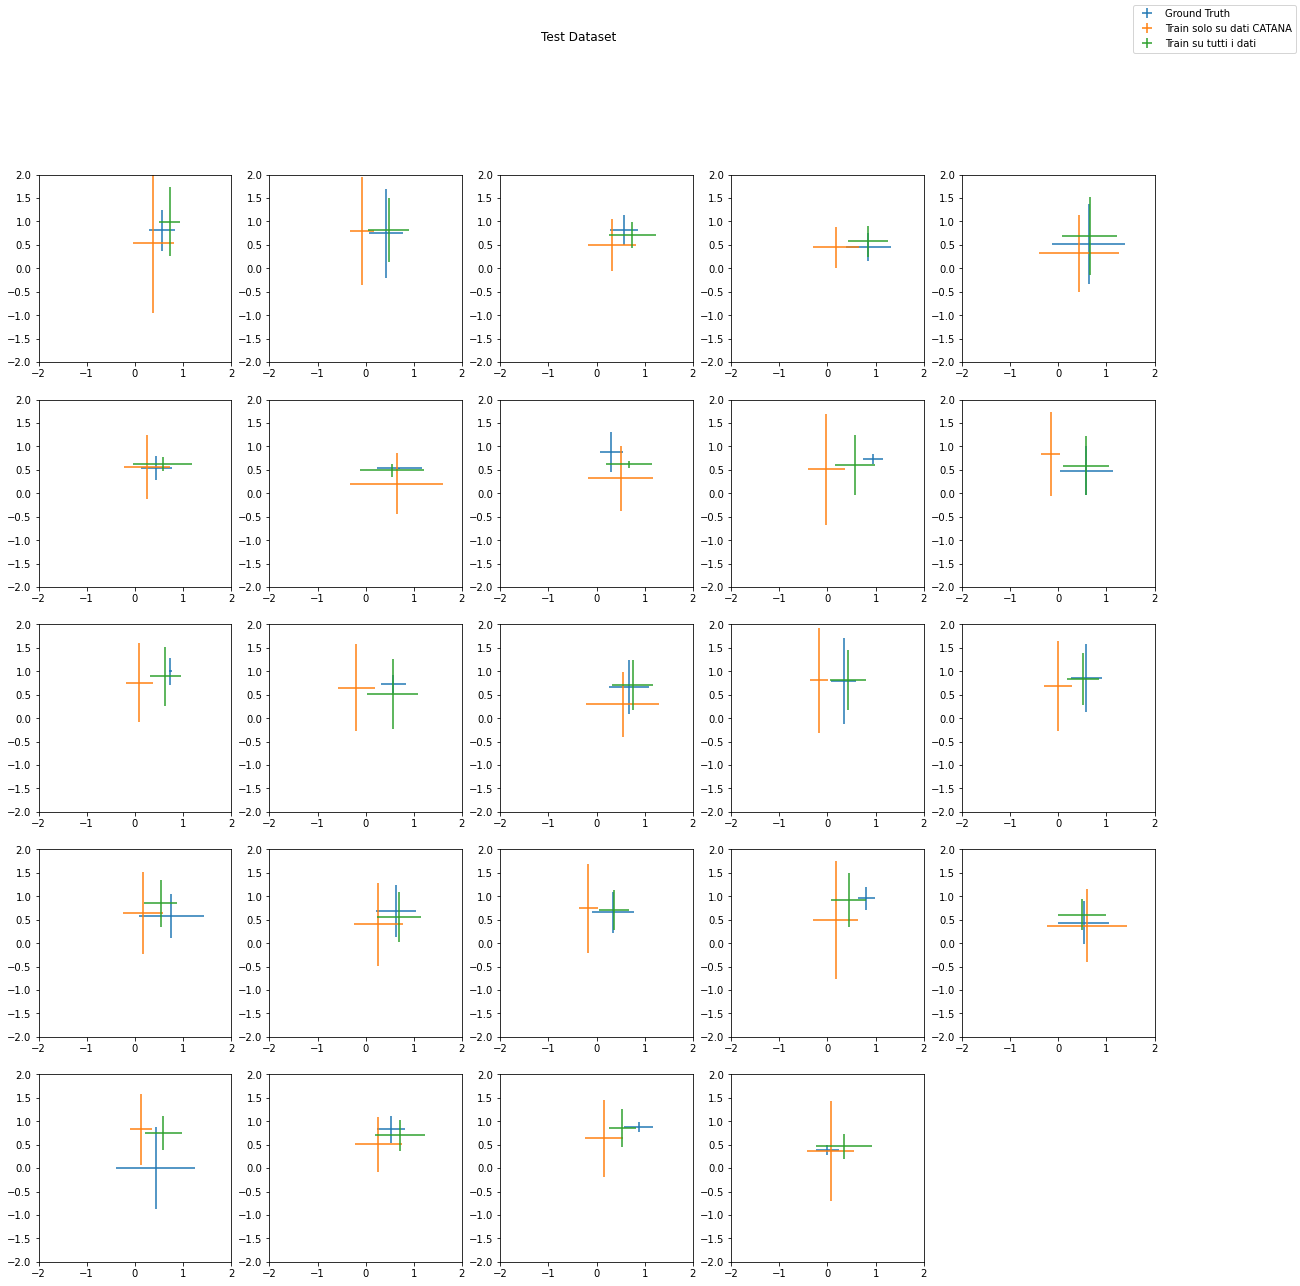

In [12]:
model1 = BeamNetV4().to(device)
model1 = torch.load("15k_Normalized_CATANA_data_BeamNetV4.py")

model2 = BeamNetV4().to(device)
model2 = torch.load("15k_Normalized_Bigger_data_BeamNetV4.py")

# Prepare data for plotting
x_train = datarray_out[:, 0].detach().cpu()
y_train = datarray_out[:, 1].detach().cpu()
sx_train = datarray_out[:, 2].detach().cpu()
sy_train = datarray_out[:, 3].detach().cpu()
x_test = datatest_out[:, 0].detach().cpu()
y_test = datatest_out[:, 1].detach().cpu()
sx_test = datatest_out[:, 2].detach().cpu()
sy_test = datatest_out[:, 3].detach().cpu()

# Prepare data for plotting
x_out_train = model1(datarray_in)[:, 0].detach().cpu()
y_out_train = model1(datarray_in)[:, 1].detach().cpu()
sx_out_train = model1(datarray_in)[:, 2].detach().cpu()
sy_out_train = model1(datarray_in)[:, 3].detach().cpu()

x_out_train_new = model2(datarray_in)[:, 0].detach().cpu()
y_out_train_new = model2(datarray_in)[:, 1].detach().cpu()
sx_out_train_new = model2(datarray_in)[:, 2].detach().cpu()
sy_out_train_new = model2(datarray_in)[:, 3].detach().cpu()


# Prepare data for plotting
x_out = model1(datatest_in)[:, 0].detach().cpu()
y_out = model1(datatest_in)[:, 1].detach().cpu()
sx_out = model1(datatest_in)[:, 2].detach().cpu()
sy_out = model1(datatest_in)[:, 3].detach().cpu()

x_out_new = model2(datatest_in)[:, 0].detach().cpu()
y_out_new = model2(datatest_in)[:, 1].detach().cpu()
sx_out_new = model2(datatest_in)[:, 2].detach().cpu()
sy_out_new = model2(datatest_in)[:, 3].detach().cpu()

##################################################################################################
# Plot Train set

plt.figure(figsize=(20, 40))
for i in range(len(x_train)):
    ax = plt.subplot(15, 5, i + 1)
    ax.errorbar(
        x_train[i],
        y_train[i],
        sx_train[i],
        sy_train[i],
        linestyle="None",
        label="Ground Truth",
    )
    ax.errorbar(
        x_out_train[i],
        y_out_train[i],
        sx_out_train[i],
        sy_out_train[i],
        linestyle="None",
        label="Model 1 Predict",
    )
    ax.errorbar(
        x_out_train_new[i],
        y_out_train_new[i],
        sx_out_train_new[i],
        sy_out_train_new[i],
        linestyle="None",
        label="Model 2 Predict",
    )
    #     ax.set_xlim([min(x_train)*0.8, max(x_train)*1.3])
    #     ax.set_ylim([min(y_train)*0.8, max(y_train)*1.3])
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
plt.suptitle("Train Dataset")
plt.figlegend(["Ground Truth", "Train solo su dati CATANA", "Train su tutti i dati"])
plt.show()


################################################################################
# Plot Test
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
for i in range(len(x_test)):
    ax = plt.subplot(5, 5, i + 1)
    ax.errorbar(
        x_test[i],
        y_test[i],
        sx_test[i],
        sy_test[i],
        linestyle="None",
        label="Ground Truth",
    )
    ax.errorbar(
        x_out[i],
        y_out[i],
        sx_out[i],
        sy_out[i],
        linestyle="None",
        label="Model 1 Predict",
    )
    ax.errorbar(
        x_out_new[i],
        y_out_new[i],
        sx_out_new[i],
        sy_out_new[i],
        linestyle="None",
        label="Model 2 Predict",
    )

    # Stessa normalizzazione di visualizzazione del train set
    #     ax.set_xlim([min(x_train)*0.8, max(x_train)*1.3])
    #     ax.set_ylim([min(y_train)*0.8, max(y_train)*1.3])
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
plt.suptitle("Test Dataset")
plt.figlegend(["Ground Truth", "Train solo su dati CATANA", "Train su tutti i dati"])
plt.show()